# Feature Overview
To demonstrate the features of mlwhatif, we will use the running example from the paper.
![overview](paper_example_image.png)

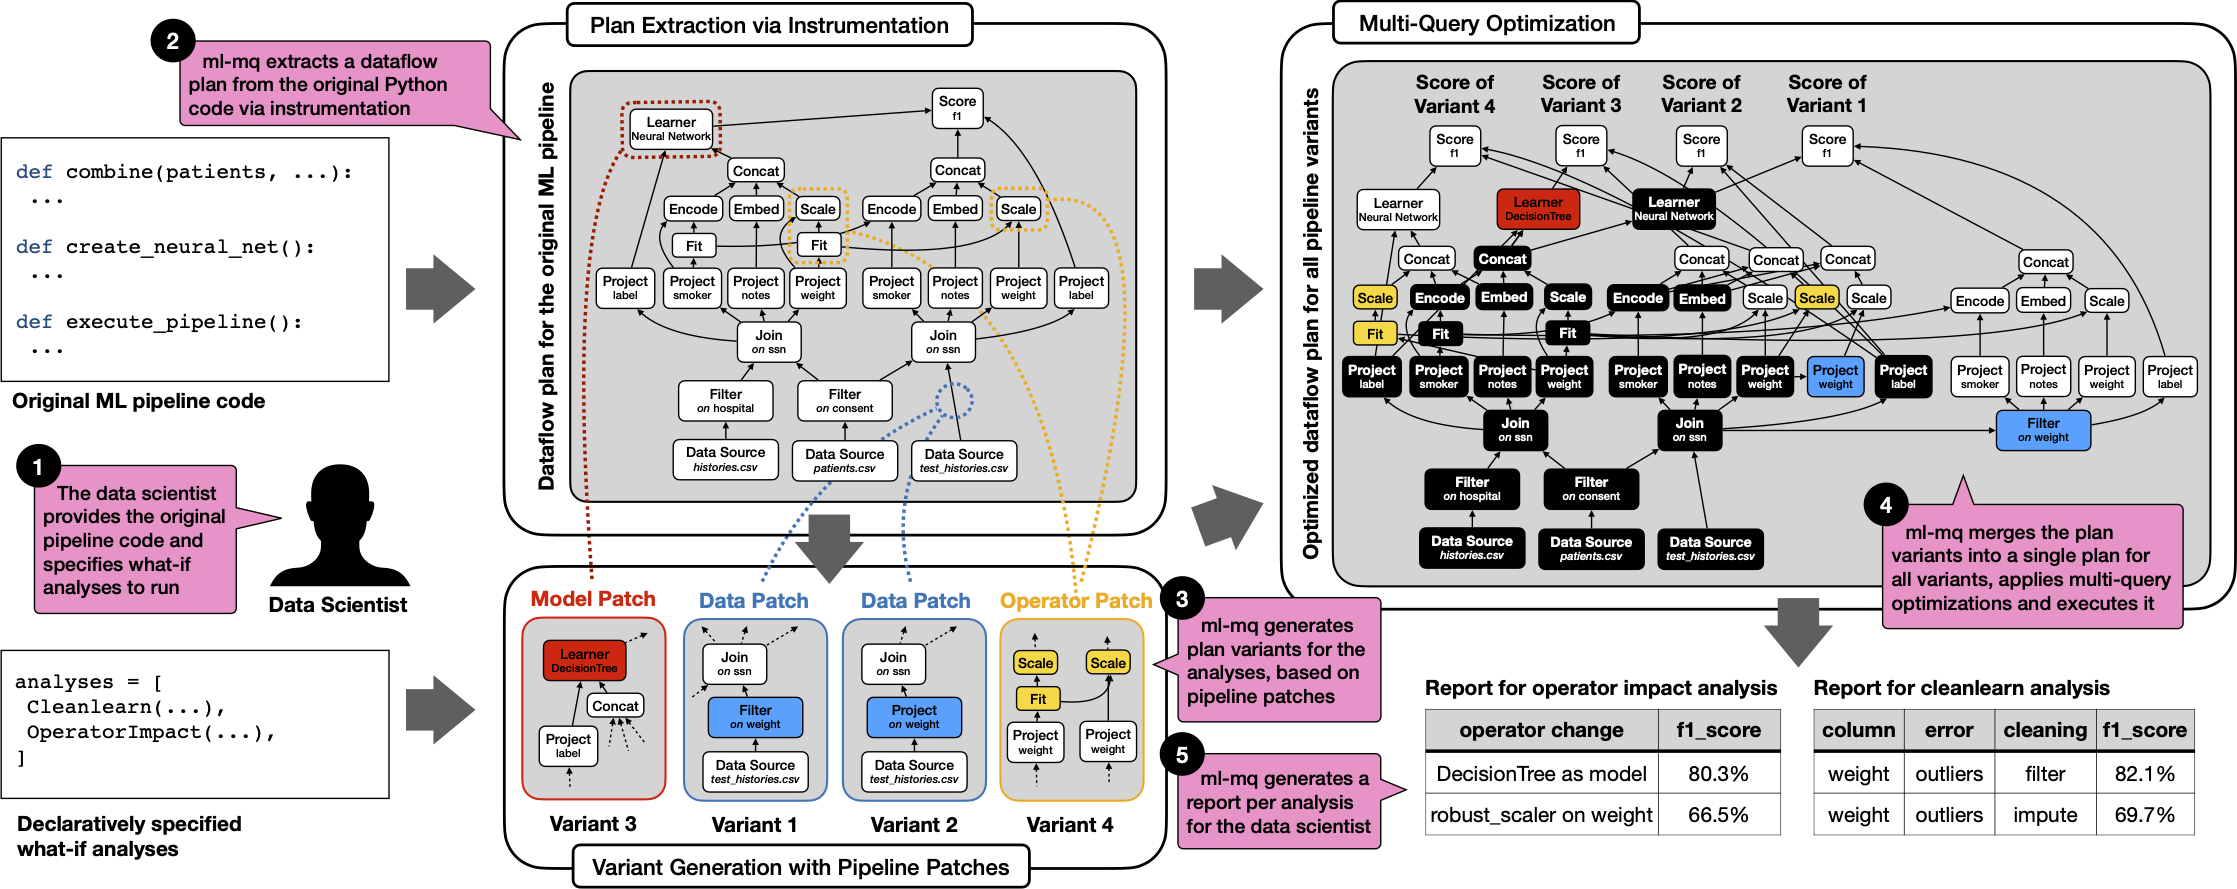

In [1]:
# Python code to load the image because the readme image doesnt work currently, maybe because the image is too big.
from functools import partial
from IPython.core.display import Image
import os
from mlwhatif.utils import get_project_root

PAPER_IMG = os.path.join(str(get_project_root()), "demo", "feature_overview",
                         "paper_example_image.png")

Image(filename=f"{PAPER_IMG}")


Let us start by looking at the full pipeline source code.

In [2]:
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import HtmlFormatter
import IPython
import os
from example_pipelines.healthcare import custom_monkeypatching
from mlwhatif.utils import get_project_root

DEMO_PY = os.path.join(str(get_project_root()), "demo", "feature_overview", "healthcare.py")

with open(DEMO_PY) as pipline_file:
    code = pipline_file.read()

formatter = HtmlFormatter()
IPython.display.HTML('<style type="text/css">{}</style>{}'.format(
    formatter.get_style_defs('.highlight'),
    highlight(code, PythonLexer(), formatter)))

To now conduct our what-if analyses, we do not need to rewrite this pipeline file, we can use it directly as input for mlwhatif. Now, let us recreate the paper example.
Cleanlearn... OperatorImpact...

In [3]:
from mlwhatif import PipelineAnalyzer
from sklearn.linear_model import LogisticRegression
from demo.feature_overview.clean_learn import Clean, ErrorType, CleanLearn
from demo.feature_overview.operator_impact import OperatorImpact
import warnings
warnings.filterwarnings('ignore')  # To keep the output readable


cleanlearn = CleanLearn(column="weight",
                        error=ErrorType.OUTLIER,
                        cleanings=[Clean.FILTER, Clean.IMPUTE],
                        outlier_func=lambda y: (y > 120) | (y < 30),
                        impute_constant=70)

op_impact = OperatorImpact(robust_scaling=True,
                           named_model_variants=[('logistic_regression', partial(LogisticRegression))])

analysis_result = PipelineAnalyzer \
    .on_pipeline_from_py_file(DEMO_PY) \
    .add_what_if_analysis(cleanlearn) \
    .add_what_if_analysis(op_impact) \
    .add_custom_monkey_patching_module(custom_monkeypatching) \
    .execute()

cleanlearn_report = analysis_result.analysis_to_result_reports[cleanlearn]
op_impact_report = analysis_result.analysis_to_result_reports[op_impact]

2022-10-14 17:35:28 INFO  Running instrumented original pipeline...
2022-10-14 17:35:28 INFO  Importing libraries and monkey-patching them... (Imports are slow if not in sys.modules cache yet!)
2022-10-14 17:35:28 INFO  ---RUNTIME: Importing and monkey-patching took 209.80286598205566 ms
2022-10-14 17:35:30 INFO  ---RUNTIME: Original pipeline execution took 1177.7501106262207 ms (excluding imports and monkey-patching)
2022-10-14 17:35:30 INFO  Starting execution of 2 what-if analyses...
2022-10-14 17:35:30 INFO  Start plan generation for analysis CleanLearn...
2022-10-14 17:35:30 INFO  ---RUNTIME: Plan generation took 0.11897087097167969 ms
2022-10-14 17:35:30 INFO  Start plan generation for analysis OperatorImpact...
2022-10-14 17:35:30 INFO  ---RUNTIME: Plan generation took 0.18787384033203125 ms
2022-10-14 17:35:30 INFO  Estimated runtime of original DAG is 1138.983964920044ms
2022-10-14 17:35:30 INFO  Performing Multi-Query Optimization
2022-10-14 17:35:30 INFO  Estimated unoptimiz

Let us start by looking at the report generated by the `cleanlab` analysis. In the first column, wee see the column that was cleaned in the tested pipeline variant. In the second column, wee see the type of errors in the column. In the third column, wee see the cleaning method tried in that variant. In the fourth column, wee see the utility score of that variant. In the first row, we see the score of the original pipeline.

Here, we find that...

In [4]:
cleanlearn_report

corrupted_column     error cleaning_method  accuracy_score_L70
0             None      None            None            0.754220
1           weight  outliers          filter            0.800719
2           weight  outliers          impute            0.808440

Next, we try looking at the report generated by the `op_impact` analysis. ...

Here, we find that...

In [5]:
op_impact_report

operator_type  operator_lineno  \
0          None              NaN   
1   Transformer             46.0   
2     Estimator             67.0   

                                       operator_code  \
0                                               None   
1                                   StandardScaler()   
2  MyKerasClassifier(create_neural_net, epochs=5,...   

          strategy_description  accuracy_score_L70  
0                         None            0.754220  
1         robust scale instead            0.700767  
2  logistic_regression instead            0.686957

Now let us look at the report. We see that the model does not rely on any single feature too much, but that `total_votes` seems to be the most important single feature.

## A small peak under the hood
Internally, mlwhatif extracts a re-executable plan of the original pipeline and uses multi-query optimization to optimize the execution of what-if analyses. Let us take a look at what this looks like for a simple example.
We will try to keep the what-if analysis very simple for readability.

In [6]:
from IPython.core.display import Image
EXAMPLE_ORIGINAL_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                          "example-orig")
EXAMPLE_INTERMEDIATE_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                              "example-intermediate")
EXAMPLE_OPTIMIZED_PLAN_PATH = os.path.join(str(get_project_root()), "demo", "feature_overview",
                                           "example-optimised")

analysis_result.save_original_dag_to_path(EXAMPLE_ORIGINAL_PLAN_PATH)
analysis_result.save_what_if_dags_to_path(EXAMPLE_INTERMEDIATE_PLAN_PATH)
analysis_result.save_optimised_what_if_dags_to_path(EXAMPLE_OPTIMIZED_PLAN_PATH)

The original DAG.

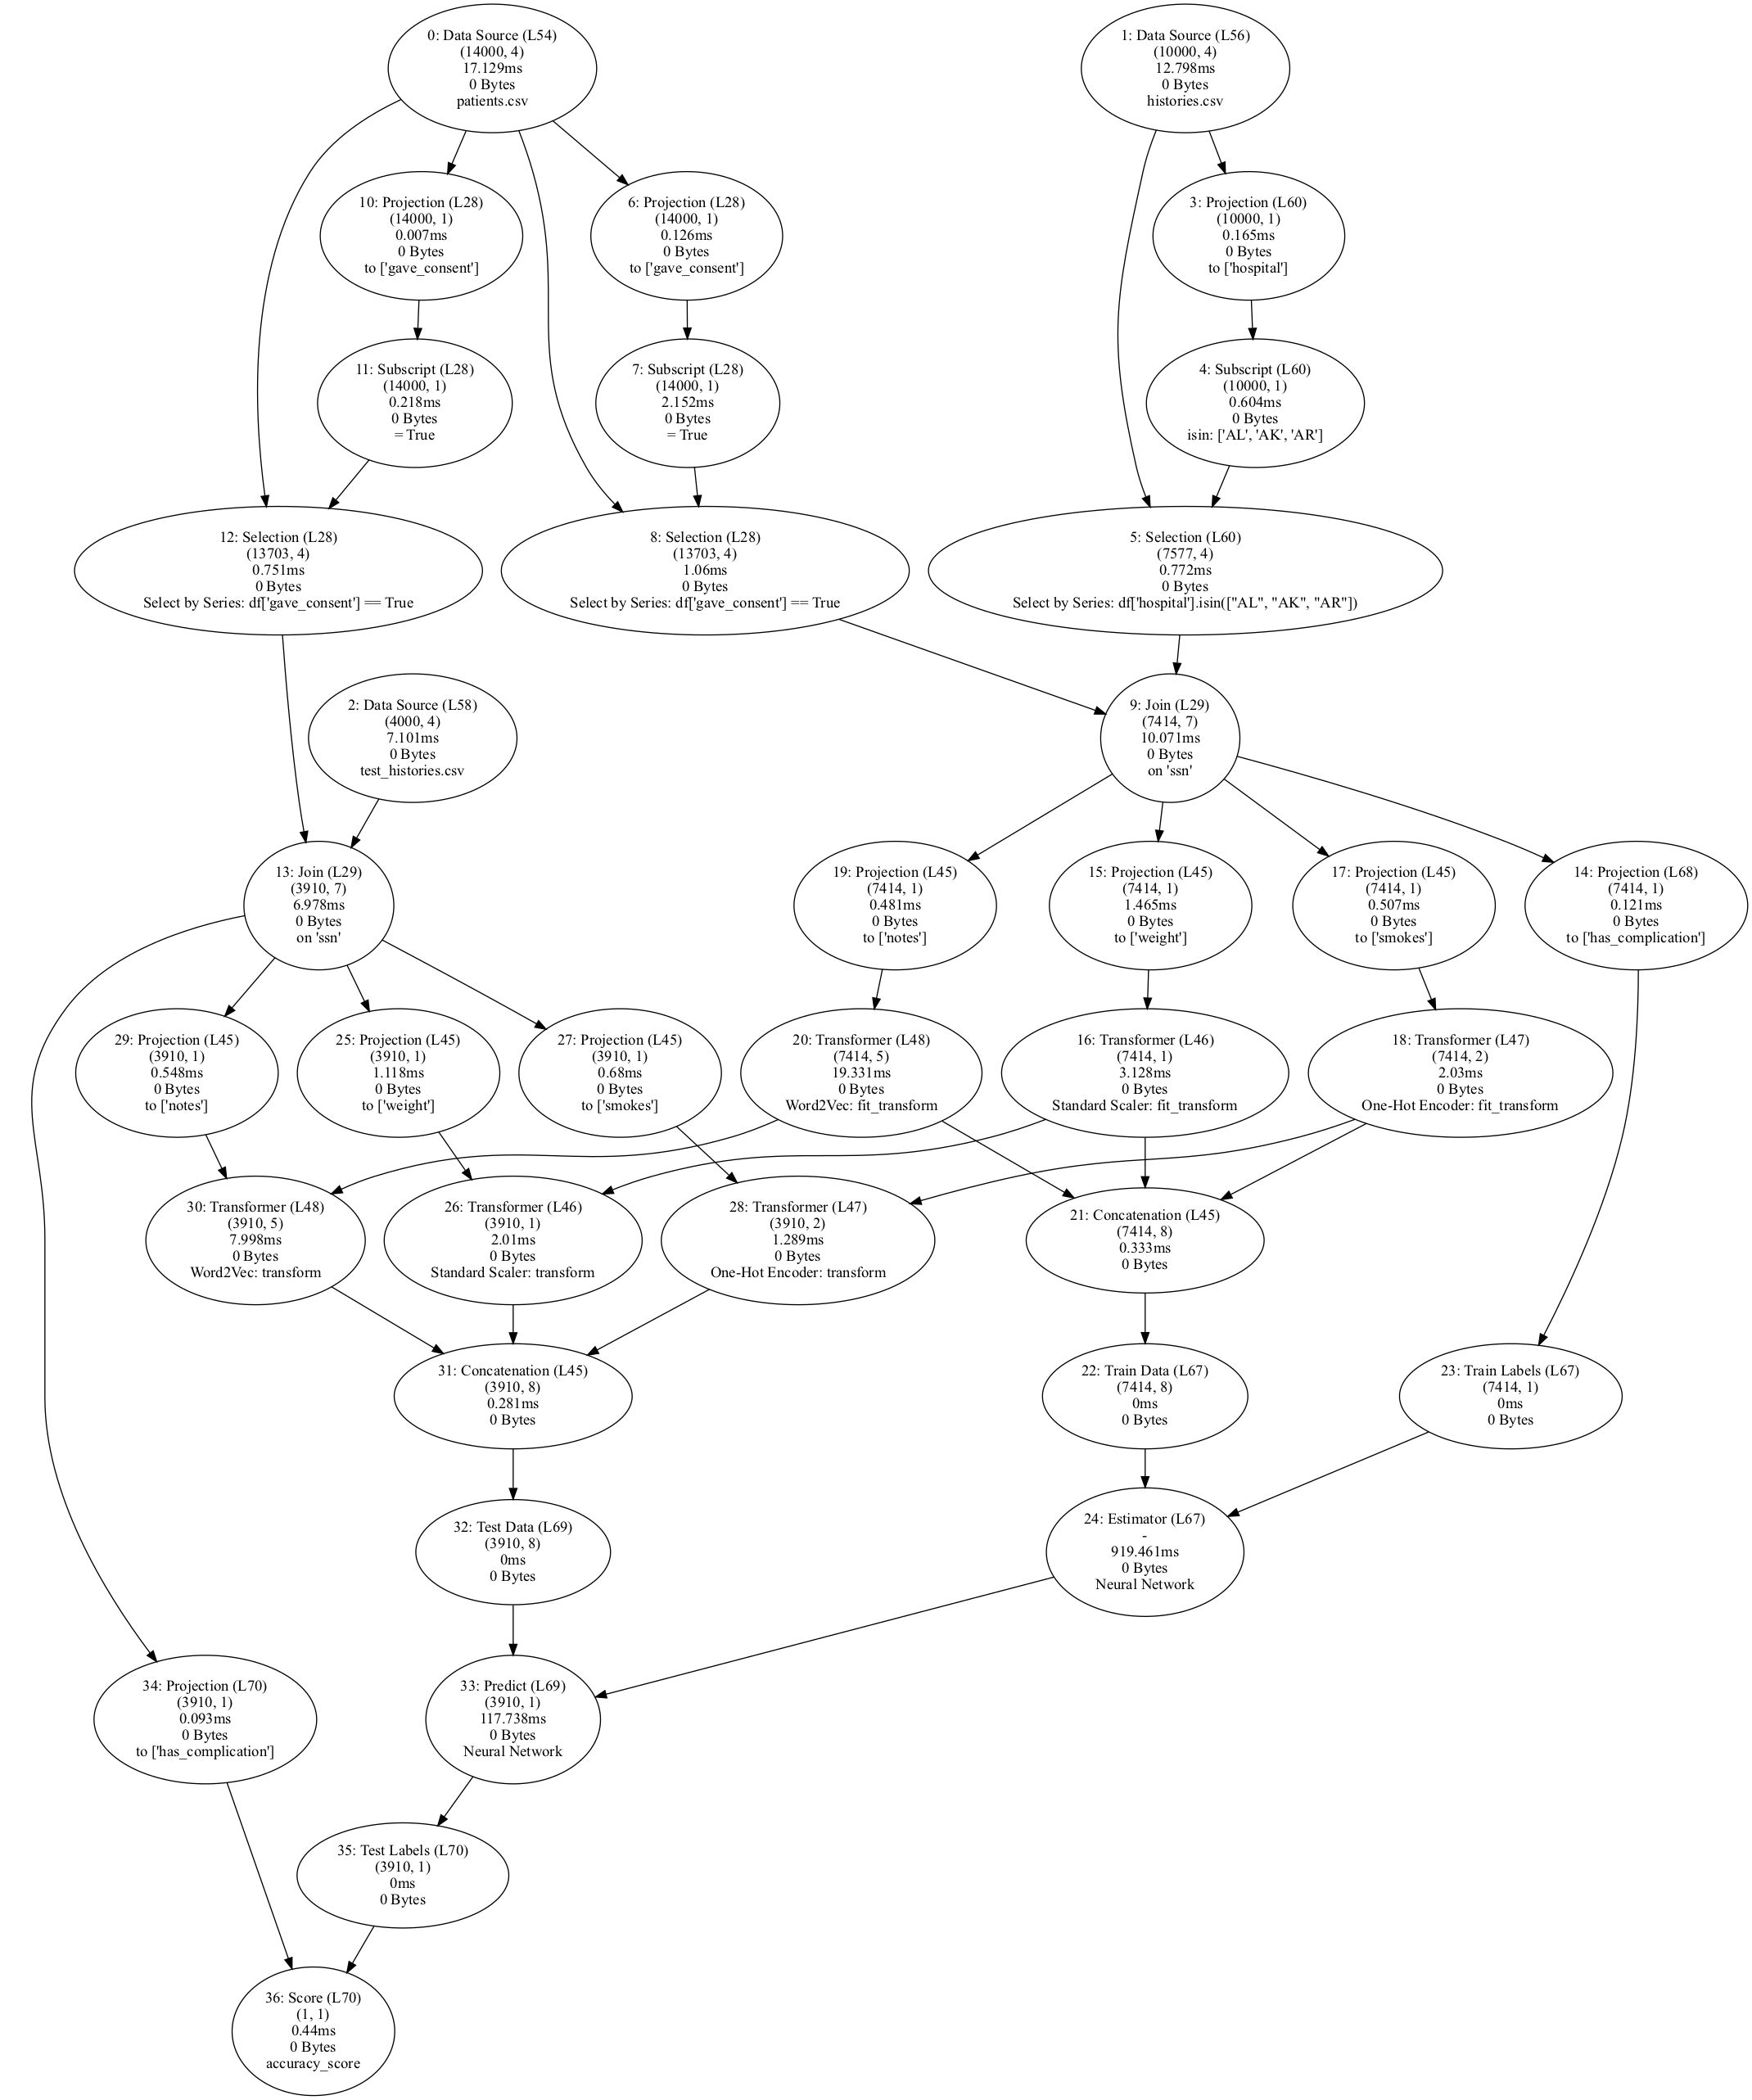

In [7]:
Image(filename=f"{EXAMPLE_ORIGINAL_PLAN_PATH}.png")

Pipeline Variant 1: Outlier filter added in the pipeline (Operator 38)

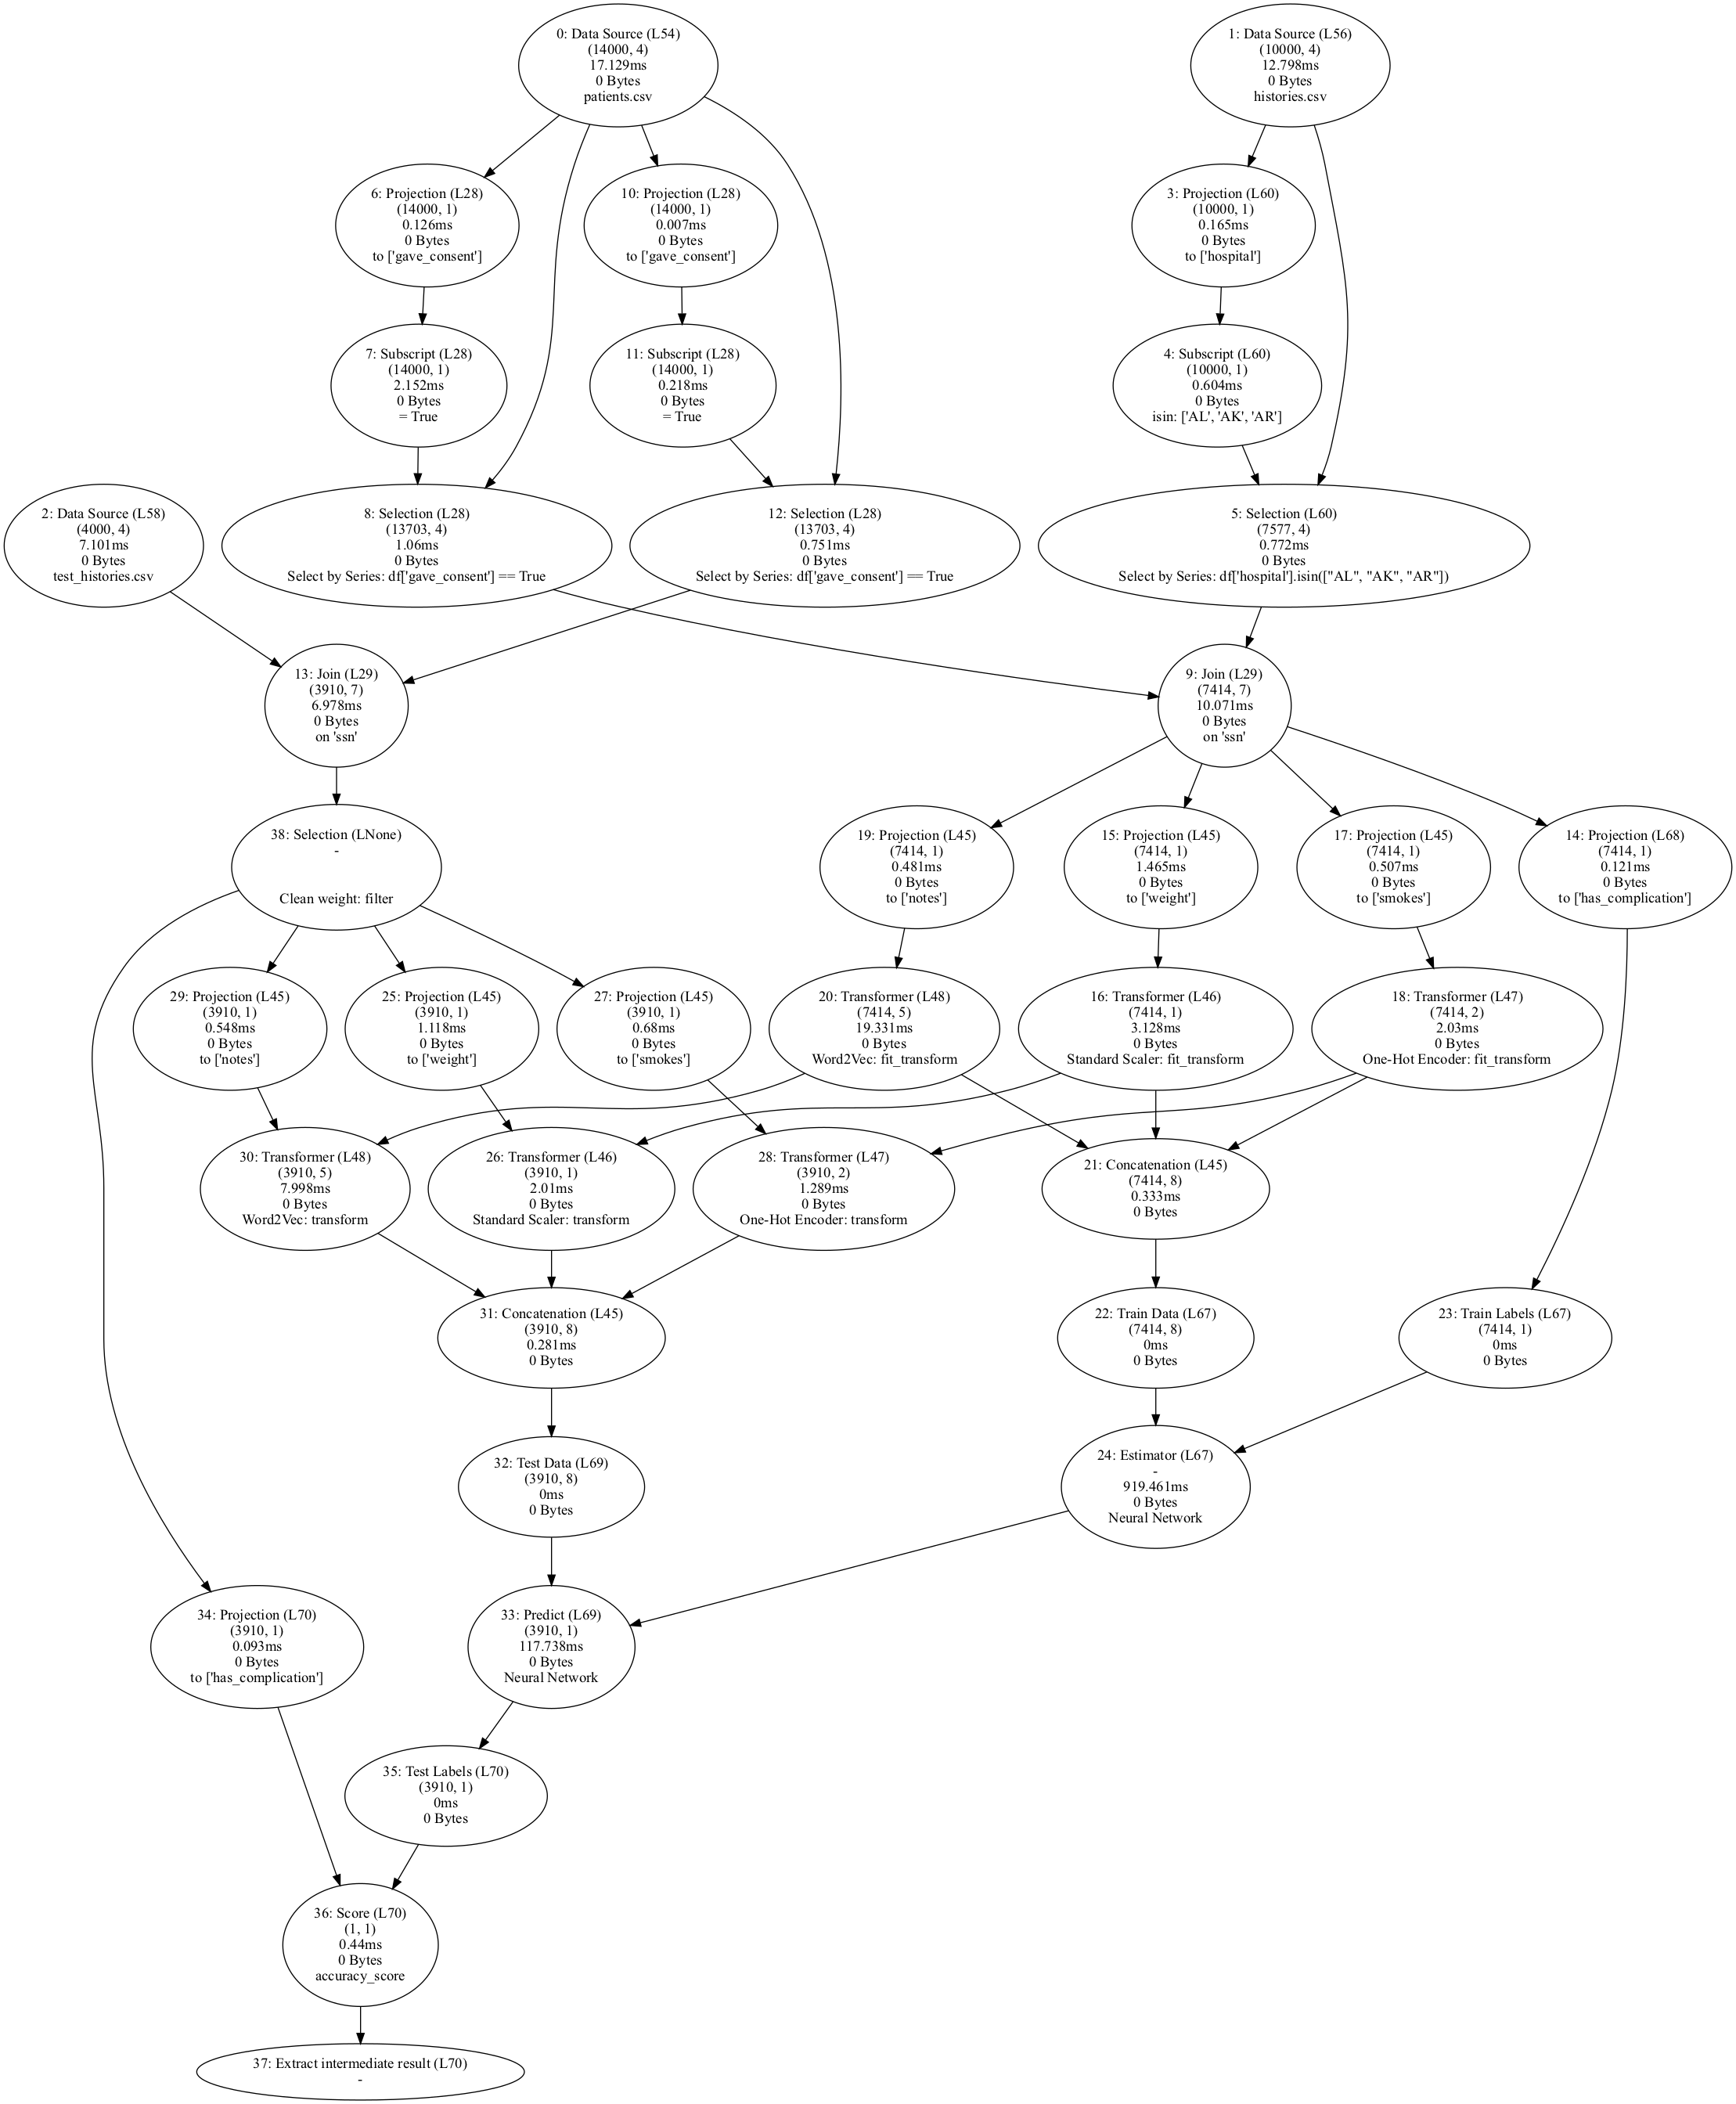

In [8]:
Image(filename=f"{EXAMPLE_INTERMEDIATE_PLAN_PATH}-0.png")

Pipeline Variant 2: Outlier replacement added in the pipeline (Operator 40)

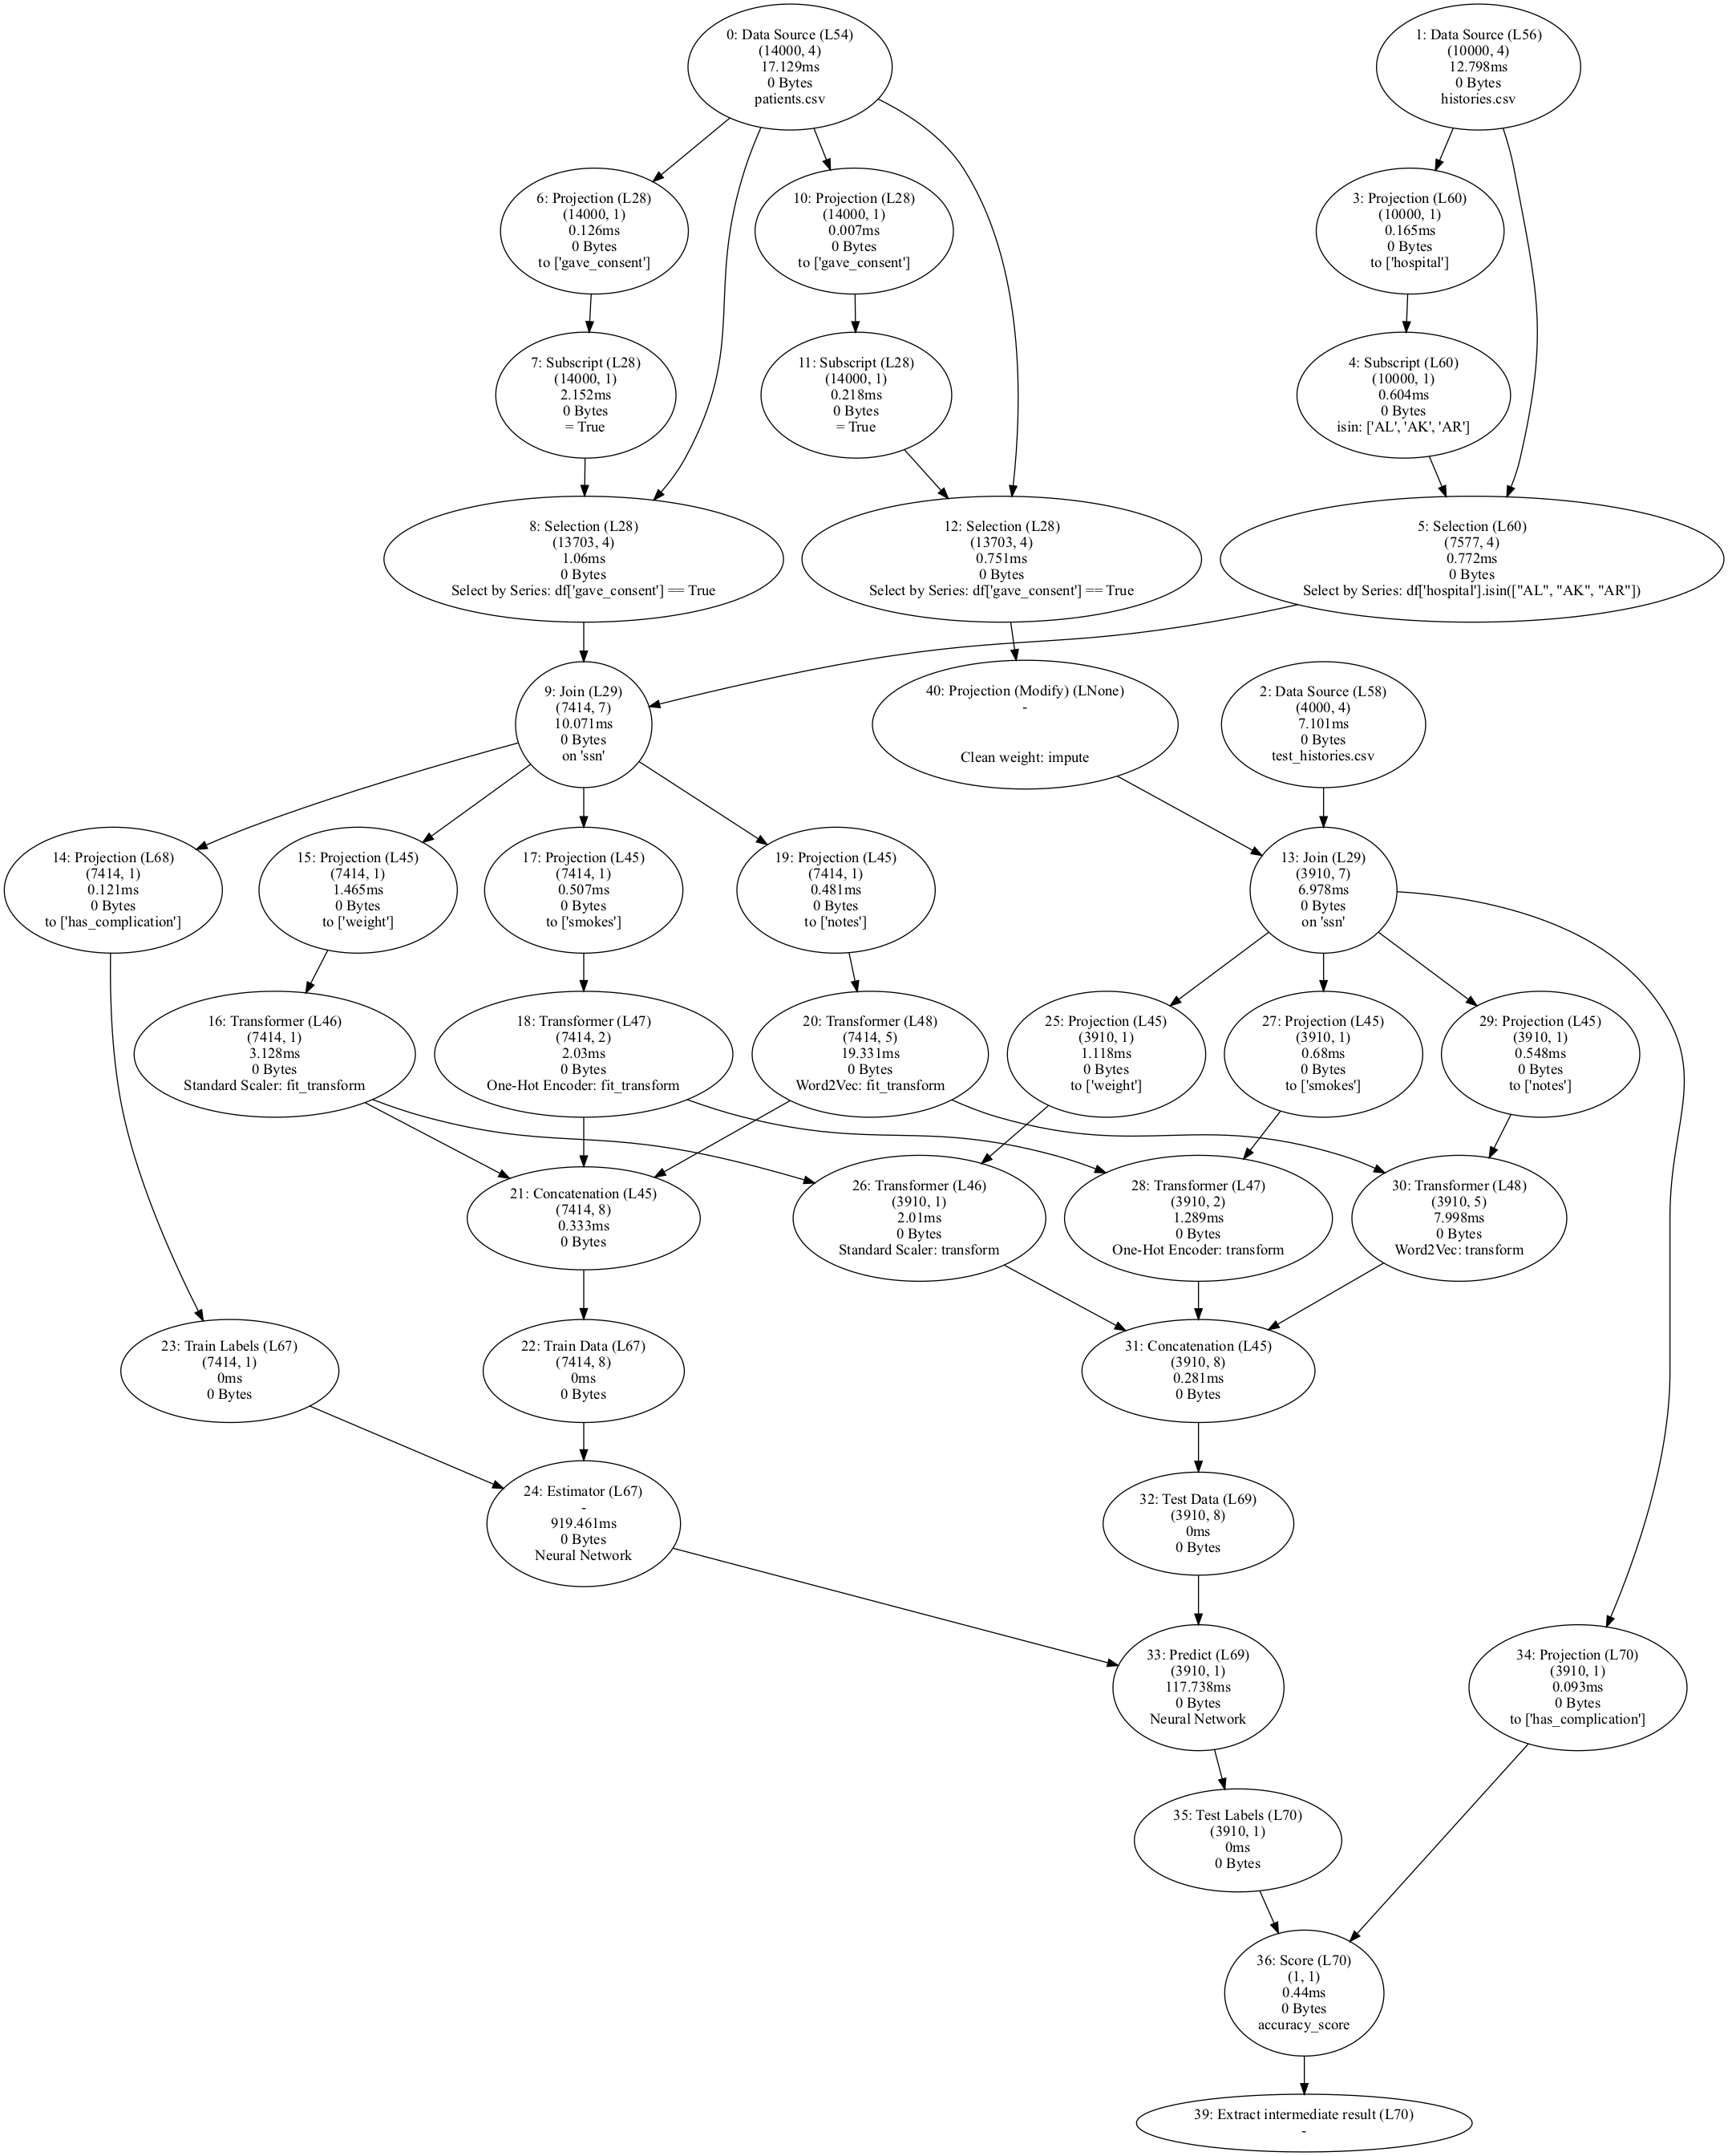

In [9]:
Image(filename=f"{EXAMPLE_INTERMEDIATE_PLAN_PATH}-1.png")

Pipeline Variant 3: Robust scalding replaced Standard Scaling in the pipeline (Operator 42)

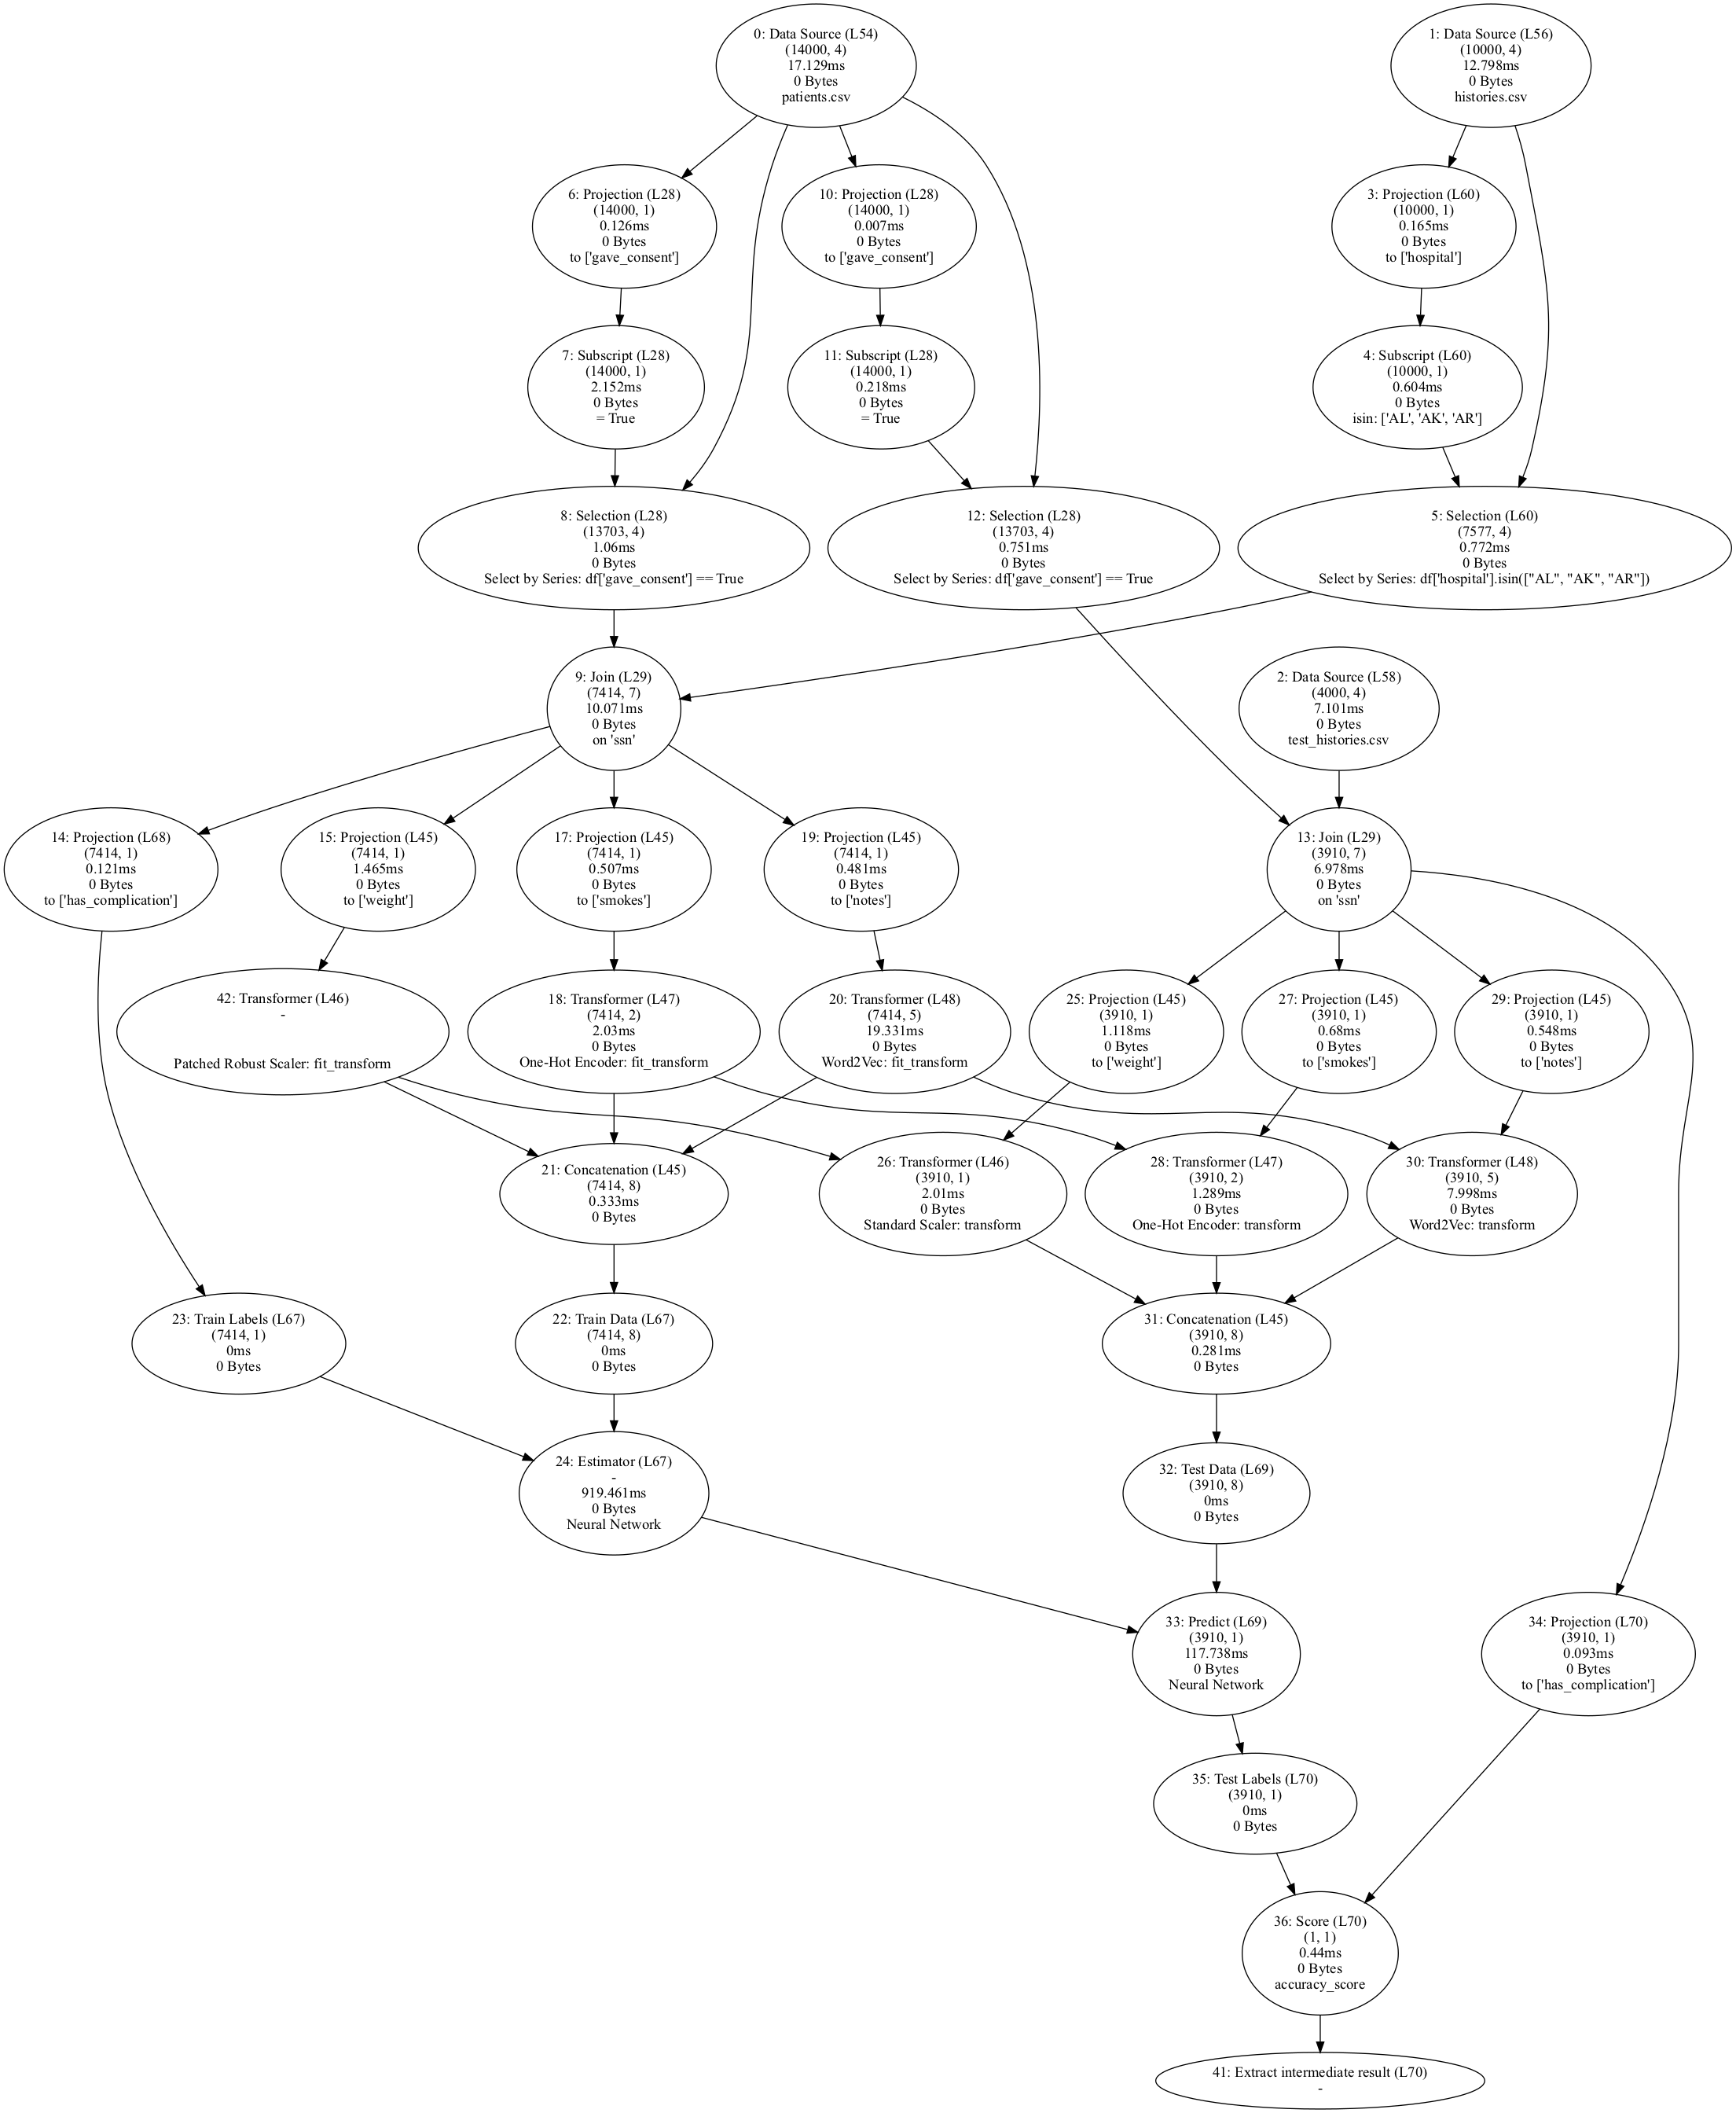

In [10]:
Image(filename=f"{EXAMPLE_INTERMEDIATE_PLAN_PATH}-2.png")

Pipeline Variant 4: Logistic Regression replaced the Neural Network in the pipeline (Operator 44)

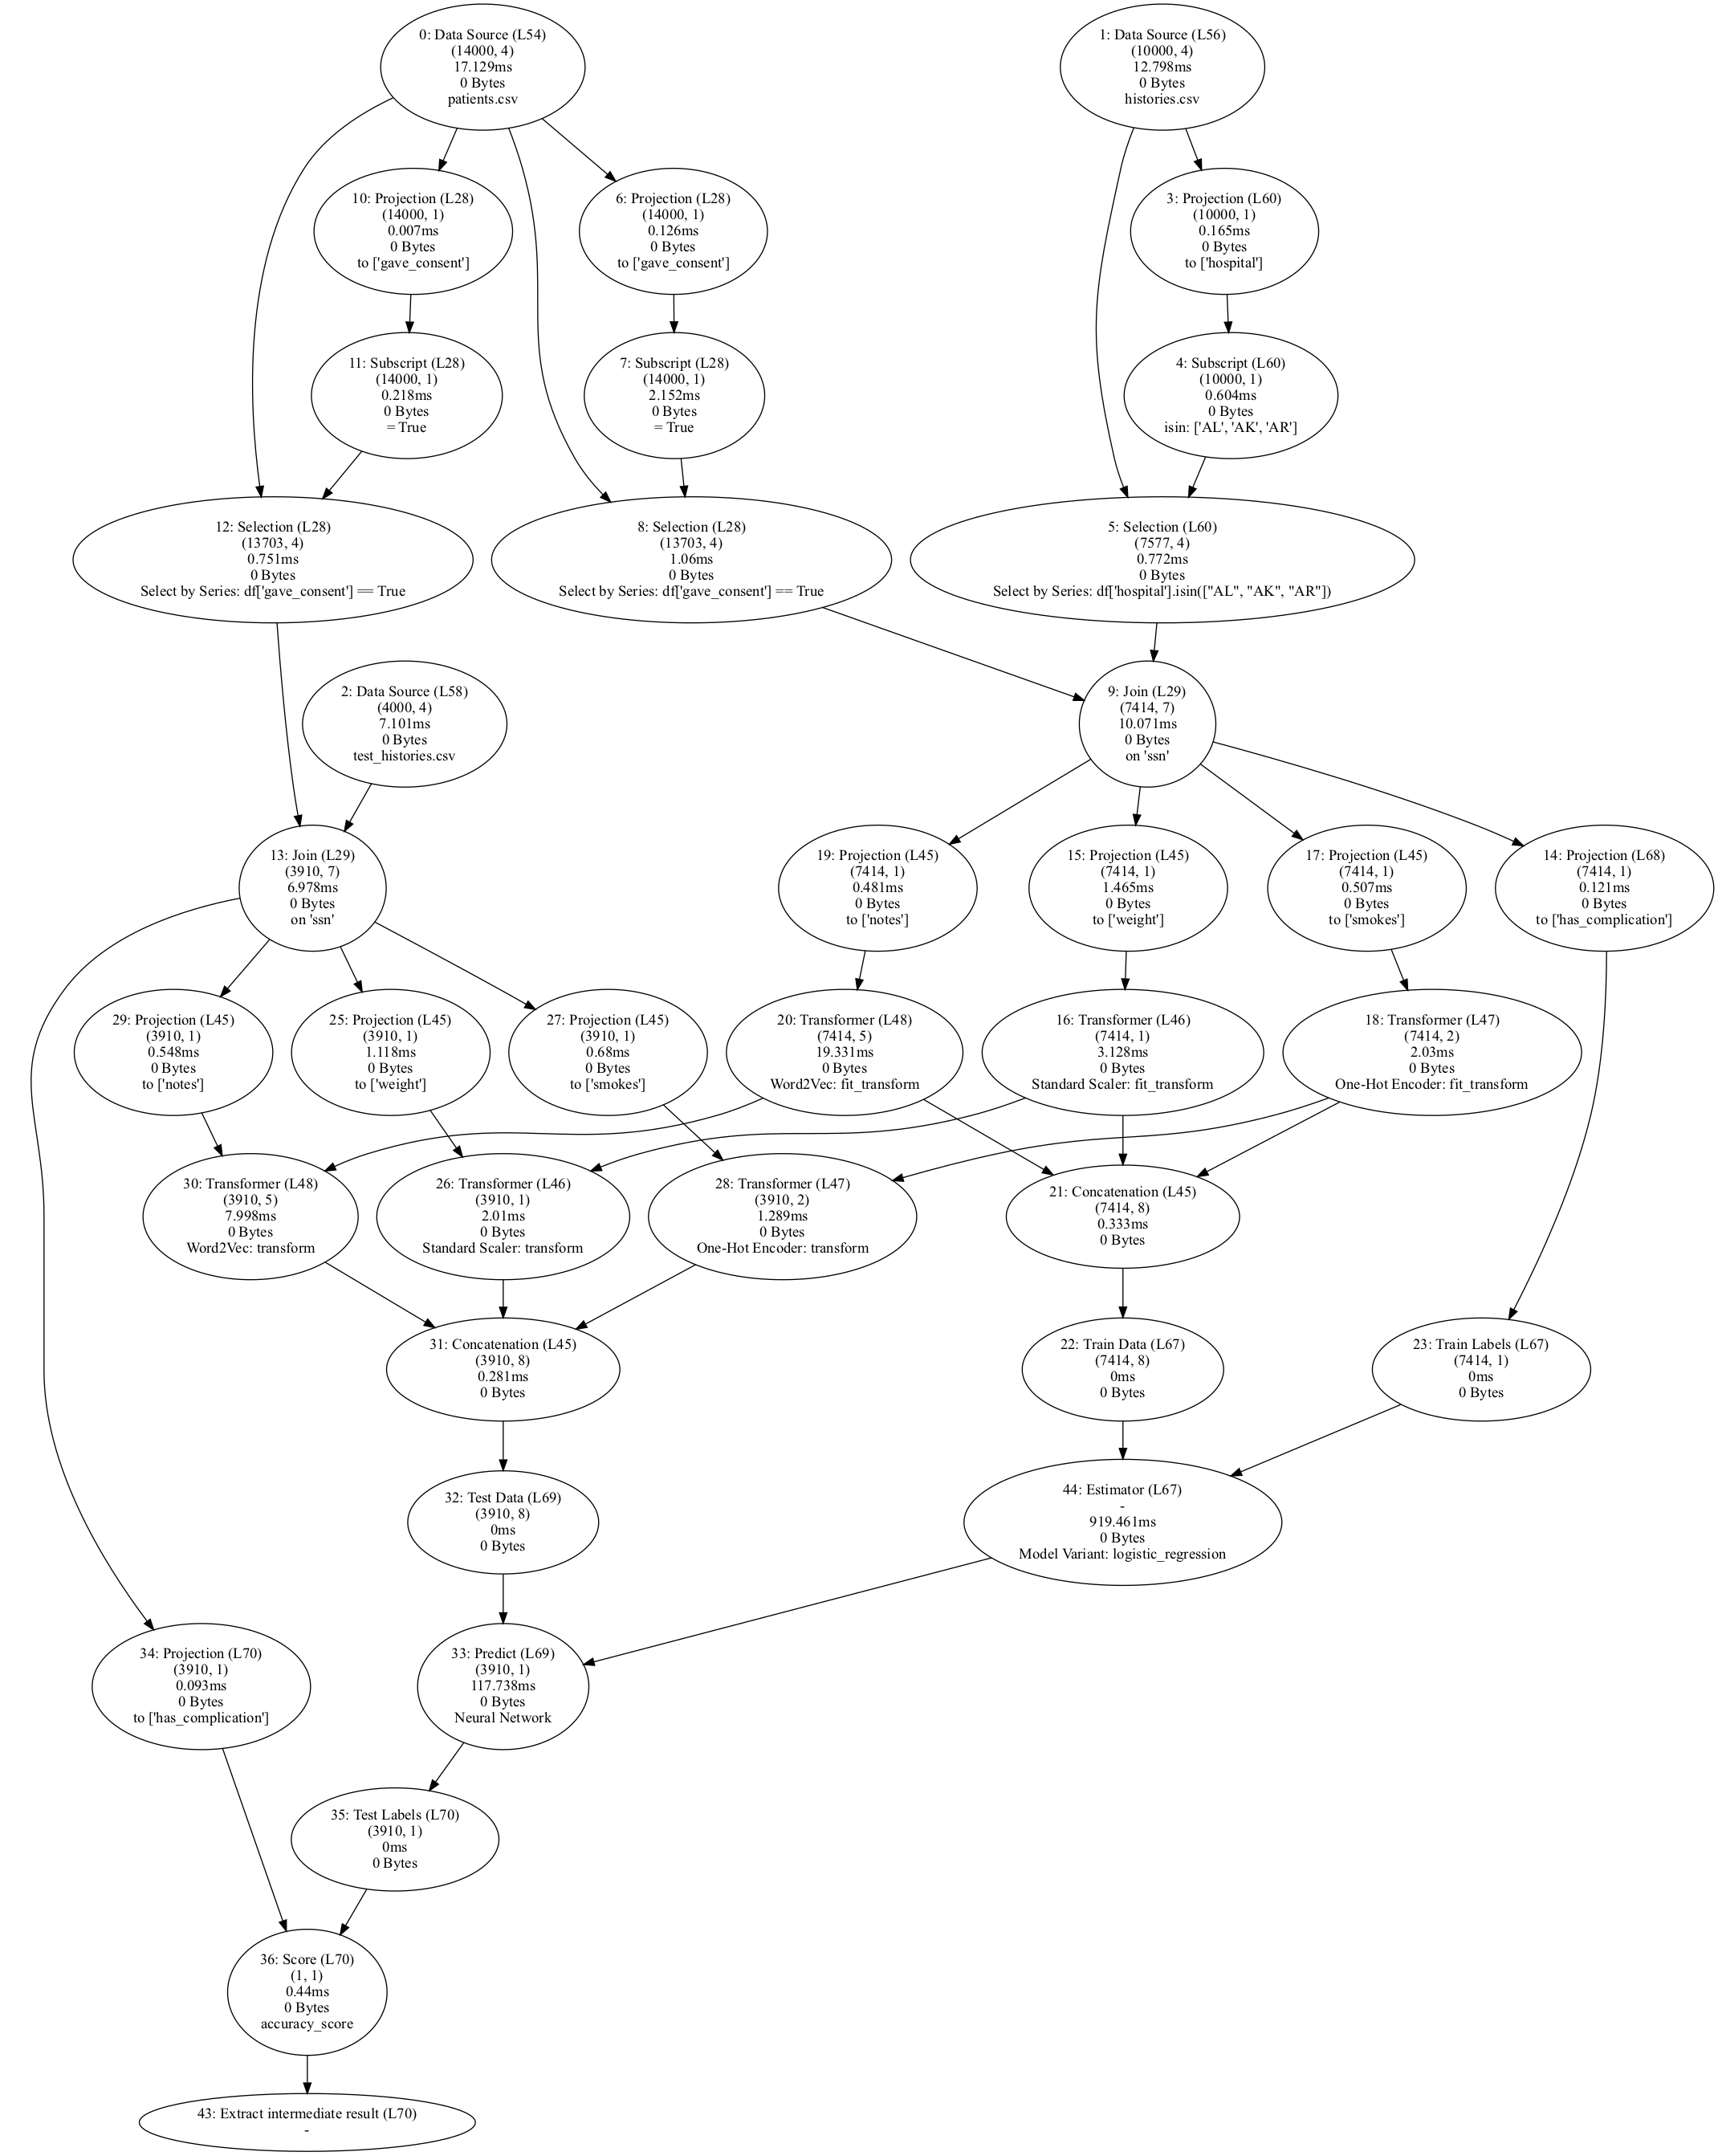

In [11]:
Image(filename=f"{EXAMPLE_INTERMEDIATE_PLAN_PATH}-3.png")

The optimised DAG, combining all the variants. Note how similar it is to the original DAG thanks to multi-query optimisation. (The patched operators are still 38, 40, 42, 44)

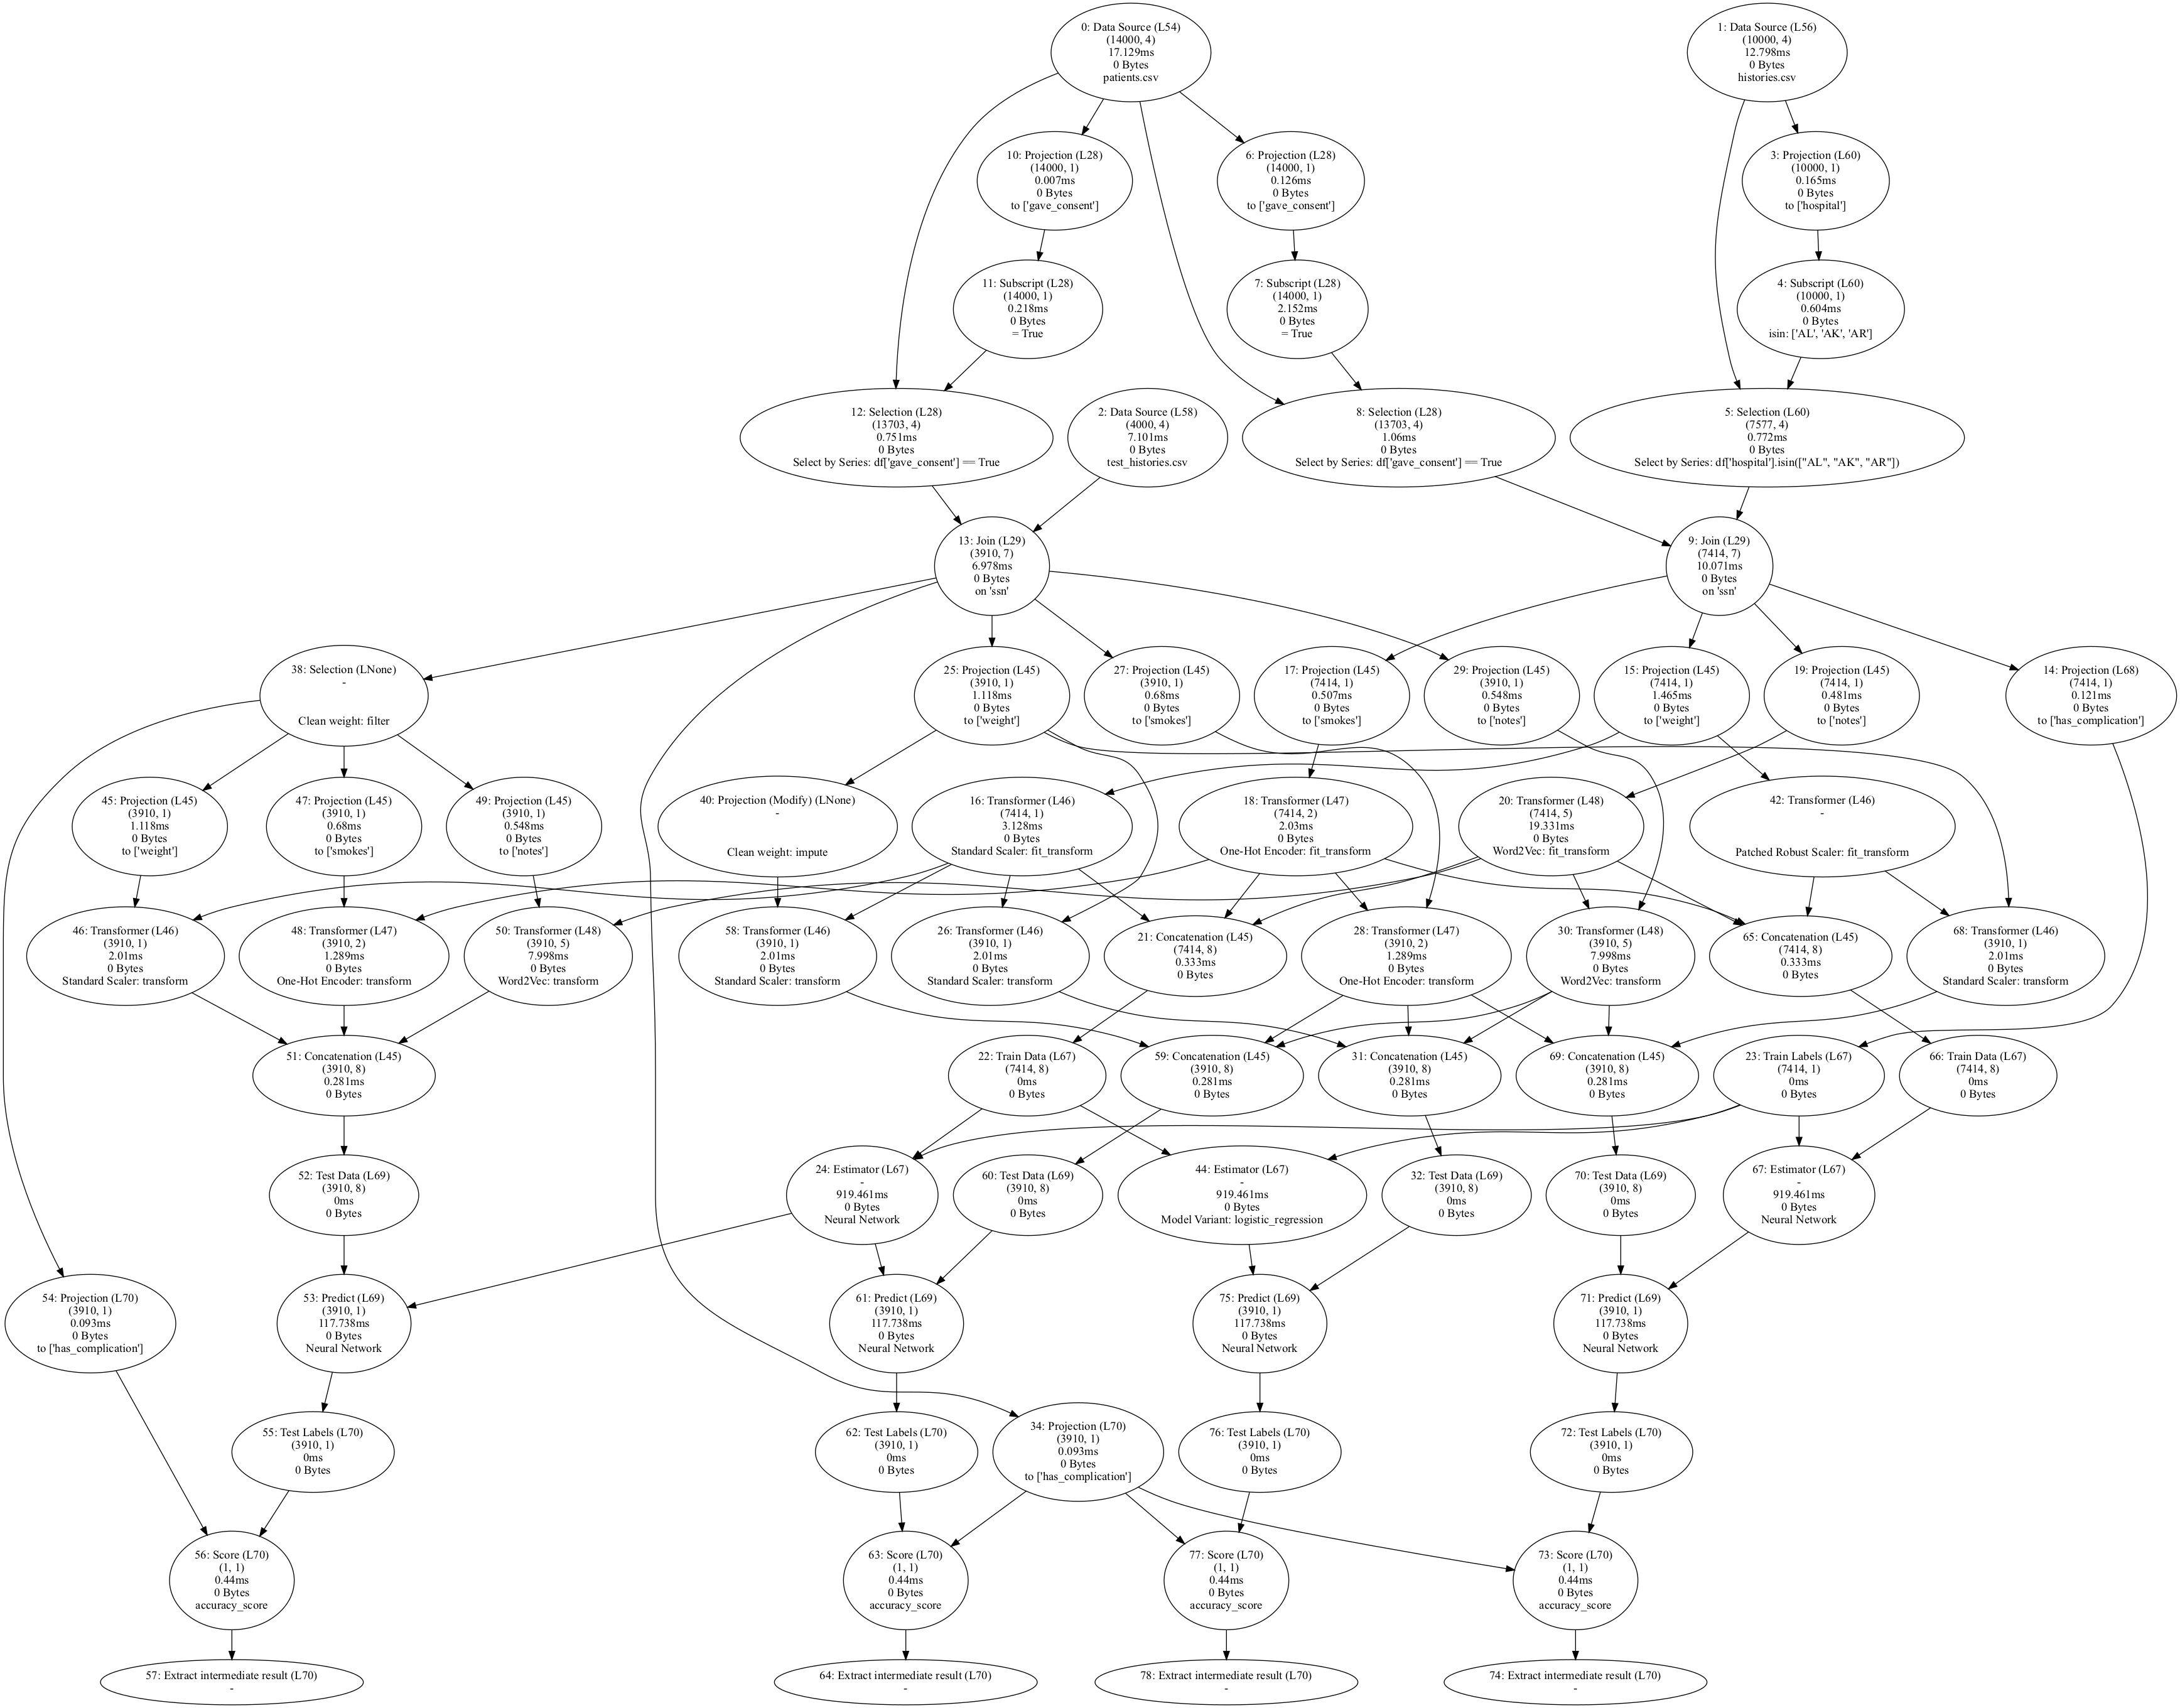

In [12]:
Image(filename=f"{EXAMPLE_OPTIMIZED_PLAN_PATH}.png")

## Further reading

In this demo notebook, we used relatively simple what-if analyses for demonstration purposes and replicated the simple example from the paper. We also prepared another demonstration notebook for advanced users already fully familiar with the ideas behind our approach. To get a full overview over our real, more powerful what-if analyses (as proposed in different papers) and a full overview over the functionality, we refer to this second notebook. (Insert link)